# Recurrent Neural Network for song lyric generation 

These sources, along with the Keras documentation were used to develop this notebook:
https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_3_text_generation.ipynb#scrollTo=WQQhz_Day39T

https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/

In [ ]:
#import necessary packages
import tensorflow as tf
from tensorflow import keras

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.callbacks import LambdaCallback
import re
import sys
import random

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
  # import data, data must be placed properly for this to work
  f = open("train.txt", "r")
  text = f.read()
  f.close()

In [ ]:
# convert the text to lowercase and remove non ASCII characters
text = text.lower()
text = re.sub(r'[^\x00-\x7f]',r'', text) 

chars = sorted(list(set(text)))
n_chars = len(text)
n_vocab = len(chars)

# print the length of the text
print('corpus length:', len(text))

#print the amount of unique characters in the set
chars = sorted(list(set(text)))
print('total chars:', n_vocab)

#map the characters to integers and map the integers to the characters
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# prepare the dataset of input to output pairs encoded as integers
seq_length = 120
dataX = []
dataY = []
step = 3
for i in range(0, len(text) - seq_length, step):
    dataX.append(text[i: i + seq_length])
    dataY.append(text[i + seq_length])
print('Total Pattern', len(dataX))

#vectorization
x = np.zeros((len(dataX), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(dataX), len(chars)), dtype=np.bool)
for i, sentence in enumerate(dataX):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[dataY[i]]] = 1


corpus length: 137149
total chars: 54
Total Pattern 45677


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
# build the model: a single LSTM
print('Building model')
model = Sequential()
model.add(LSTM(256, input_shape=(seq_length, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
print("Model built")
model.summary()

Building model
Model built
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               318464    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 54)                13878     
                                                                 
Total params: 332,342
Trainable params: 332,342
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#define lists to store the generated text, Loss scores, and epochs
generated_lyrics = []
Loss = []
Epochs = []

In [ ]:

def sample(preds):
    # helper function to sample an index from a probability array, works like softmax
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 0.2 # number here is from scale factor (temperature)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# add class to print text as its generated
class call_back(keras.callbacks.Callback):
  def __init__(self):
      super(call_back, self).__init__()

  def on_epoch_end(self, epoch, logs=None):
      # Function invoked at end of each epoch. Prints generated text.
      print("******************************************************")
      print('----- Generating text after Epoch: %d' % epoch)
      Loss.append(logs.get("loss"))
      Epochs.append(epoch)
      start_index = random.randint(0, len(text) - seq_length - 1)
      generated = ''
      sentence = text[start_index: start_index + seq_length]
      generated += sentence
      print('----- Generating with seed: "' + sentence + '"')
      sys.stdout.write(generated)

      for i in range(400):
          x_pred = np.zeros((1, seq_length, len(chars)))
          for t, char in enumerate(sentence):
              x_pred[0, t, char_indices[char]] = 1.

          preds = model.predict(x_pred, verbose=0)[0]
          next_index = sample(preds)
          next_char = indices_char[next_index]

          generated += next_char
          sentence = sentence[1:] + next_char
          sys.stdout.write(next_char)
          sys.stdout.flush()
      print()
      plt.ylabel("Loss")
      plt.xlabel("Epochs")
      plt.title("Loss Over Epochs")
      plt.tight_layout()
      plt.plot(Epochs, Loss);
      generated_lyrics.append(generated)

Epoch 1/80
357/357 [==============================] - ETA: 0s - loss: 2.9164******************************************************
----- Generating text after Epoch: 0
----- Generating with seed: "s with police officers
'til i'm deceased in a coffin
please, your disdain for the brothers ain't gon' change the numbers"
s with police officers
'til i'm deceased in a coffin
please, your disdain for the brothers ain't gon' change the numbers the the the the se the the se the the the the the the the the the the the the the the gin the the the the the the the the the de the the the the the the the the the the the the the the in the the the the the the the the the to the the the the the the the the the the the the the the the the the the the the the the the the the the the the the de the te the the the the the the the the the the the th
357/357 [==============================] - 49s 122ms/step - loss: 2.9164
Epoch 2/80
357/357 [==============================] - ETA: 0s - loss: 2.4604***********

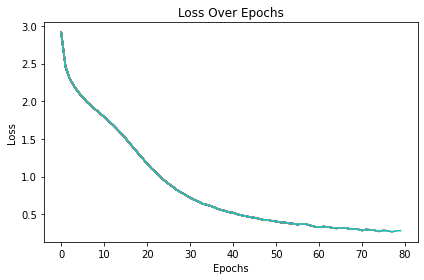

In [ ]:
#fit the model
model.fit(x, y, epochs=80, batch_size=128, callbacks=call_back())

In [ ]:
#save results
with open('Adjusted_RNN.txt', 'w') as f:
    for item in generated_lyrics:
        f.write("%s\n" % item)
f.close()

In [ ]:
!pip install fast_bleu

  Created wheel for fast-bleu: filename=fast_bleu-0.0.90-cp37-cp37m-linux_x86_64.whl size=581441 sha256=6516c66b0b8166700f938101277b8e8edbf2e41f7dd0d8f8d8e0b58d6b53e0b9
  Stored in directory: /root/.cache/pip/wheels/bb/68/af/8d3adf7eca3609c20e9c59b27187deb5e7134b52c9df2233d0
Successfully built fast-bleu


In [ ]:
# establish reference corpus
ref_corpus = []
with open('250_lyrics_train.txt') as ref_file:
    ref_lines = ref_file.readlines()
    for i in ref_lines:
      ref_corpus.append(i)

In [ ]:
from fast_bleu import BLEU, SelfBLEU

list_of_references = ref_corpus
hypotheses = generated_lyrics

weight = [0] * 4
weights = {}
for n_gram in range(1,5):
    weight[n_gram - 1] = 1.0
    weights['bleu-{}'.format(n_gram)] = tuple(weight)
    weight[n_gram - 1] = 0.0
    avg_weight = [1. / n_gram] * n_gram
    avg_weight.extend([0. for index in range(4 - n_gram)])
    weights['bleu-{}-avg'.format(n_gram)] = tuple(avg_weight)

bleu = BLEU(list_of_references, weights)
results = bleu.get_score(hypotheses)

bleu_dict = {}
for n_gram in range(1,5):
    bleu_dict['bleu-{}'.format(n_gram)] = []
for n_gram in range(1,5):
    bleu_dict['bleu-{}'.format(n_gram)].append(np.array(results['bleu-{}'.format(n_gram)]).mean())
print(bleu_dict)

{'bleu-1': [0.837324295346361], 'bleu-2': [0.779765498601608], 'bleu-3': [0.7730128451310123], 'bleu-4': [0.7089188986718792]}
